In [6]:
import pandas as pd
import time
import logging
import os
import praw
import re
from prawcore.exceptions import TooManyRequests, RequestException
from dotenv import load_dotenv
from datetime import datetime

In [7]:
democrat_keywords = [
    # General Democrat references
    'democrat', 'dems', 'liberal', 'libs', 'left-wing', 'leftist', 'snowflake', 
    'blue wave', 'democratic party', 'progressive', 'woke', 'sjw', 'social justice warrior',

    # Joe Biden
    'biden', 'joe biden', 'sleepy joe', 'creepy joe', 'joey', 'the big guy', 'potato', 
    'senile joe', 'bidenflation', 'brandon', 'lets go brandon', 'bribem', 

    # Kamala Harris
    'kamala', 'harris', 'kamala harris', 'heels up', 'heels up harris', 'knee pads', 'cameltoe harris', 
    'kamal', 'kamalala', 'mala mala', 'cackling harris', 'veep harris', 'madam vp', 'vp harris',

    # Nancy Pelosi
    'pelosi', 'nancy pelosi', 'crazy nancy', 'auntie nancy', 'nancypants', 'nasty nancy', 'pelo-clown', 

    # Barack Obama
    'obama', 'barack obama', 'obummer', 'nobama', 'barry', 'barry soetoro',

    # Alexandria Ocasio-Cortez
    'aoc', 'alexandria ocasio-cortez', 'ocrazio', 'aocrazio', 'ocasiotard', 'aocloon', 'aoc clown', 'green new deal girl', 
    'sandy', 'bartender',

    # Bernie Sanders
    'bernie', 'bernie sanders', 'comrade sanders', 'bernout', 'feel the bern', 'grandpa socialism', 'old bernie', 'crazy bernie',

    # Elizabeth Warren
    'elizabeth warren', 'warren', 'pocahontas', 'fauxcahontas', 'lizzie warren', 'warren the warrior', 'chief warren',

    # Other prominent Democrats
    'hillary', 'hillary clinton', 'crooked hillary', 'killary', 'clinton', 'chelsea clinton', 'the clintons', 
    'adam schiff', 'schifty schiff', 'shifty schiff', 'jerry nadler', 'fat jerry',

    # Voters/supporters
    'dem voter', 'democrats supporter', 'lib voter', 'woke mob', 'sjw army', 'antifa', 'lefty', 'blm', 'black lives matter', 
    'democrat loyalist', 'progressive left', 'radical left', 'anarchist', 'feminazi', 'the squad'
]

democrat_keywords = [keyword.lower() for keyword in democrat_keywords]

republican_keywords = [
    # General Republican references
    'republican', 'gop', 'right-wing', 'rightie', 'conservative', 'maga', 'red wave', 'republican party', 
    'patriot', 'nationalist', 'the right', 'alt-right', 'alt right', 'chud', 'repubtard', 'repugs', 

    # Donald Trump
    'trump', 'donald trump', 'donald', 'the donald', 'orange man', 'orangutan', 'orangeman bad', 'drumpf', 'trumpster', 
    'trumptard', 'trumpkin', 'the cheeto', 'cheeto jesus', 'maga king', 'god emperor', 'tangerine tyrant', '45', 
    'donald dump', 'trumpanzee', 'trumplethinskin', 'trumpenstein', 'orange'

    # Other Trump family members
    'melania', 'melania trump', 'ivanka', 'ivanka trump', 'eric trump', 'donald jr', 'don jr', 'tiffany trump', 'barron trump',

    # Ted Cruz
    'ted cruz', 'lyin ted', 'cruz missile', 'creepy cruz', 'texas senator', 

    # Mitch McConnell
    'mitch mcconnell', 'mcconnell', 'mitch the turtle', 'mitch', 'moscow mitch', 'the turtle',

    # Ron DeSantis
    'ron desantis', 'desantis', 'deathsantis', 'florida man', 'governor desantis', 'ron the con', 'rondesantis', 'rondan', 

    # Lindsey Graham
    'lindsey graham', 'lady g', 'graham cracker', 'closet graham', 'senator graham', 'miss lindsey', 

    # Other prominent Republicans
    'mike pence', 'pence', 'iron mike', 'deputy dog', 'kevin mccarthy', 'sean hannity', 'tucker carlson', 
    'matt gaetz', 'gaetz', 'fox news', 'gutfeld', 'tom cotton', 'josh hawley', 'lauren boebert', 'marjorie taylor greene', 
    'mgt', 'green new deal reject',

    # Voters/supporters
    'maga voter', 'maga mob', 'trump voter', 'trumpist', 'patriot', 'republican loyalist', 'trump supporter', 
    'deplorable', 'qanon', 'trump army', 'right-winger', 'christian conservative', 'militia', 'gun rights', '2nd amendment'
]

republican_keywords = [keyword.lower() for keyword in republican_keywords]

In [8]:
import re
# Logging configuration
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    handlers=[logging.StreamHandler(), 
                              logging.FileHandler(r"C:\Users\34616\Documents\4GEEKS\datos_gordos\reddit\Scraping_results\final_scraper.log", mode='a')])


# Functions to check for relevant keywords
def contains_keywords(text, keyword_list):
    if not text:
        return False
    for keyword in keyword_list:
        # si la keyword es una frase, buscar la frase entera
        if ' ' in keyword:
            if keyword.lower() in text.lower():
                return True
        else:
            # si la keyword es una palabra, buscamos únicamente la palabra entera (no substrings) 
            if re.search(r'\b' + re.escape(keyword) + r'\b', text.lower()):
                return True
    return False

def contains_republican_keyword(text):
    return contains_keywords(text, republican_keywords)

def contains_democrat_keyword(text):
    return contains_keywords(text, democrat_keywords)

def is_relevant_content(text):
    text = text.lower()
    if not text or len(text.strip()) == 0:
        return False
    bot_phrases = [
        "i am a bot", "this bot", "automoderator", 
        "bot created", "beep boop", "bleep bloop", 
        "bot detected", "this is a reminder from the bots",
        "your post has been removed", "your comment has been removed", 
        "moderator action", "subreddit rules", 
        "thank you for your submission", "follow the subreddit rules", 
        "please read our community guidelines", "crosspost", "x-post", "r/"
    ]

    if any(phrase in text for phrase in bot_phrases):
        return False

    if re.search(r'http[s]?://', text):
        return False

    if len(text) < 20 or text in ['thanks', 'lol', 'ok', 'i agree', 'no', 'what']:
        return False

    return True

def relabel_posts(df):
    new_labels = []

    for text in df['text']:
        democrat_found = contains_democrat_keyword(text)
        republican_found = contains_republican_keyword(text)

        if democrat_found and republican_found:
            new_labels.append('Both')
        elif democrat_found:
            new_labels.append('Democrat')
        elif republican_found:
            new_labels.append('Republican')
        if not text:
            new_labels.append('None')
        else:
            new_labels.append('None')
    
    # Update the DataFrame with the new labels
    df['labels'] = new_labels
    return df

In [9]:
# Subreddits to scrape
subreddits = ['politics', 'PoliticalDiscussion', 'Conservative', 'Liberal', 'ModeratePolitics', 'Ask_Politics', 'Democrats', 'Republican']

# DataFrame columns
columns = ['text', 'submission_type', 'subreddit', 'label']

# Rate limiting backoff
initial_backoff = 5
max_backoff = 300
backoff_factor = 2

output_file = r"C:\Users\34616\Documents\4GEEKS\datos_gordos\reddit\Scraping_results\final_version\final_scrape_v2.csv"

def save_progress(df_buffer):
    global i
    try:
        if not df_buffer.empty:
            logging.info("Saving current progress...")

            # Check the file exists and append or create new
            file_exists = os.path.isfile(output_file)

            # Actually save the progress to file
            df_buffer.to_csv(output_file, mode='a', header=not file_exists, index=False)
            logging.info(f"Saved {len(df_buffer)} records successfully. (i = {i})")
        else:
            logging.info(f"No records to save (empty buffer). i = {i}")
    except Exception as e:
        logging.error(f"Error saving progress: {e}")


def backoff_sleep(attempt):
    sleep_time = min(initial_backoff * (backoff_factor ** attempt), max_backoff)
    logging.info(f"Rate limit hit. Attempt {attempt} Sleeping for {sleep_time} seconds...")
    time.sleep(sleep_time)


In [10]:
# Initializing Reddit API
load_dotenv()
user_agent = "final scrape /u/speedylean"
reddit = praw.Reddit(client_id=os.getenv('REDDIT_ID'),
                     client_secret=os.getenv('REDDIT_SECRET'),
                     user_agent=user_agent)


In [11]:

def scrape_subreddit(subreddit_name, limit):
    max_attempts = 100
    global i, records_collected 
    save_threshold = 25000
    buffer = []
    subreddit = reddit.subreddit(subreddit_name)
    logging.info(f"Now scraping r/{subreddit_name}. i = {i}")

    # Fetching posts with error handling
    attempt = 0
    while attempt < max_attempts:
        try:
            posts = list(subreddit.hot(limit=limit))
            logging.info(f"Fetched {len(posts)} posts from r/{subreddit_name}")
            break
        
        except TooManyRequests as e:
            logging.warning(f"Rate limit hit when fetching posts from r/{subreddit_name}: {e}")
            backoff_sleep(attempt)
            attempt += 1

        except RequestException as e:
            logging.error(f"Request exception when fetching posts from r/{subreddit_name}: {e}")
            backoff_sleep(attempt)
            attempt += 1

        except Exception as e:
            logging.error(f"Unhandled exception when fetching posts from r/{subreddit_name}: {e}")
            break
    else:
        logging.error(f"Max attempt reached for fetching posts from r/{subreddit_name}. Skipping")

    for post in posts:

        # checking the label of the title

        if contains_democrat_keyword(post.title) and contains_republican_keyword(post.title):
            label = 'Both'
        elif contains_democrat_keyword(post.title):
            label = 'Democrat'
        elif contains_republican_keyword(post.title):
            label = 'Republican'
        else:
            label= 'None'
    
        # saving the title
        record = {
        'text': post.title,
        'submission_type': 'title',
        'subreddit': subreddit_name,
        'label': label
        }
        buffer.append(record)
        records_collected += 1
        i +=1

        attempt = 0
        while attempt < max_attempts:
            try:
                post.comments.replace_more(limit=None)
                comments = post.comments.list()
                break
            except TooManyRequests as e:
                logging.warning(f"Rate limit hit when fetching comments: {e}. i = {i}")
                backoff_sleep(attempt)
                attempt += 1
                
            except RequestException as e:
                logging.error(f"Request exception when fetching comments: {e}")
                backoff_sleep(attempt)
                attempt += 1
               
            except Exception as e:
                logging.error(f"Unhandled exception when fetching comments: {e}")
                break
        else: 
            logging.error(f"Max attempts reached to fetch comments from post {post.id}. Skipping.")
  
        
        # Processing comments
        for comment in comments:
            if not is_relevant_content(comment.body):
                continue

            if contains_democrat_keyword(comment.body) and contains_republican_keyword(comment.body):
                label = 'Both'
            elif contains_democrat_keyword(comment.body):
                label = 'Democrat'
            elif contains_republican_keyword(comment.body):
                label = 'Republican'
            else:
                continue

            record = {
                'text': comment.body,
                'submission_type': 'comment',
                'subreddit': subreddit_name,
                'label': label
            }
            buffer.append(record)
            records_collected += 1
            i +=1

            # Save progress every save_threshold records
            if records_collected >= save_threshold:
                logging.info(f"Save threshold hit")
                df_buffer = pd.DataFrame(buffer, columns=columns)
                save_progress(df_buffer)
                buffer = []
                records_collected = 0

    # Save remaining records
    if buffer:
        df_buffer = pd.DataFrame(buffer, columns=columns)
        save_progress(df_buffer)

In [12]:
def main(subreddits):
    global i, records_collected
    records_collected = 0
    i = 0
    for subreddit in subreddits:
        scrape_subreddit(subreddit, limit=None)
        logging.info(f"Finished scraping r/{subreddit}")
        logging.info(f"Data scraped so far: {i} instances.")

    logging.info("Scraping complete.")


main(subreddits)

2024-09-13 08:22:06,645 - INFO - Now scraping r/politics. i = 0
2024-09-13 08:22:16,160 - INFO - Fetched 838 posts from r/politics
2024-09-13 08:29:57,549 - WARNING - Rate limit hit when fetching comments: received 429 HTTP response. i = 1721
2024-09-13 08:29:57,550 - INFO - Rate limit hit. Attempt 0 Sleeping for 5 seconds...
2024-09-13 08:59:57,487 - WARNING - Rate limit hit when fetching comments: received 429 HTTP response. i = 13646
2024-09-13 08:59:57,488 - INFO - Rate limit hit. Attempt 0 Sleeping for 5 seconds...
2024-09-13 09:29:57,559 - WARNING - Rate limit hit when fetching comments: received 429 HTTP response. i = 22538
2024-09-13 09:29:57,560 - INFO - Rate limit hit. Attempt 0 Sleeping for 5 seconds...
2024-09-13 09:39:57,531 - WARNING - Rate limit hit when fetching comments: received 429 HTTP response. i = 24817
2024-09-13 09:39:57,532 - INFO - Rate limit hit. Attempt 0 Sleeping for 5 seconds...
2024-09-13 09:41:38,706 - INFO - Save threshold hit
2024-09-13 09:41:38,717 - 

In [17]:
import pandas as pd
df = pd.read_csv(r"C:\Users\34616\Documents\4GEEKS\datos_gordos\reddit\Scraping_results\final_version\final_scrape_v2.csv")
df

,text,submission_type,subreddit,label
0,"/r/Politics' 2024 US Elections Live Thread, Pa...",title,politics,NaN
1,"""Kamala didn't talk about policy."" She did but...",comment,politics,Democrat
2,Let’s spend time talking about why “concepts o...,comment,politics,Both
3,My dad voted for Trump in 2016 and 2020.\n\nHe...,comment,politics,Republican
4,I just donated to the Harris campaign - my fir...,comment,politics,Democrat
...,...,...,...,...
238406,There's an Update on the Voting Machine Compan...,title,Republican,NaN
238407,The Logic Is Simple And Undeniable,title,Republican,NaN
238408,These memes are all funny and true but simply ...,comment,Republican,Republican
238409,"A fool, A idiot and a moron walked into a vot...",comment,Republican,Democrat


In [18]:
df['label'].value_counts()

label
Republican    102823
Democrat       70995
Both           61314
Name: count, dtype: int64

In [20]:
df['subreddit'].value_counts()

subreddit
PoliticalDiscussion    84781
ModeratePolitics       70164
politics               57717
Democrats               7424
Republican              5452
Conservative            5144
Liberal                 4062
Ask_Politics            3667
Name: count, dtype: int64

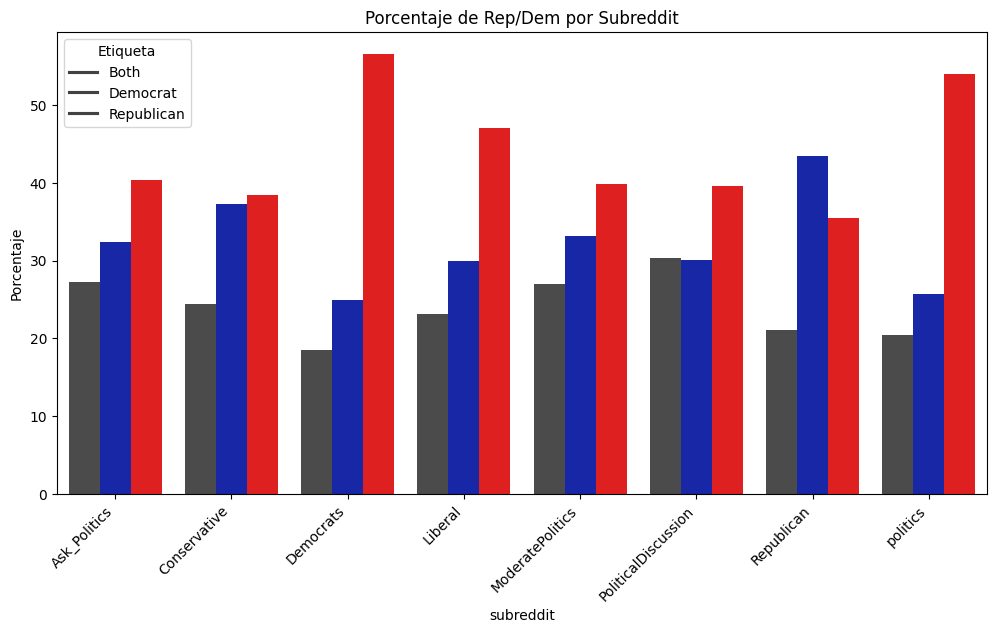

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentage of each label (Democrat/Republican) per subreddit
def calculate_label_percentages(df):
    subreddit_label_counts = df.groupby(['subreddit', 'label']).size().reset_index(name='count')
    subreddit_total_counts = df.groupby('subreddit').size().reset_index(name='total')
    
    # Merge to get the total counts for each subreddit
    merged = pd.merge(subreddit_label_counts, subreddit_total_counts, on='subreddit')
    
    # Calculate percentage
    merged['percentage'] = (merged['count'] / merged['total']) * 100
    return merged

def plot_label_distribution_by_subreddit(df):
    # Calculate the percentage data
    percentage_data = calculate_label_percentages(df)

    plt.figure(figsize=(12, 6))
    
    # Set the color palette using the official party colors
    palette = {'Republican': '#FF0000', 'Democrat': '#0015BC', 'Both': '#4B4B4B'}
    
    sns.barplot(data=percentage_data, x='subreddit', y='percentage', hue='label', palette=palette)
    
    plt.title('Porcentaje de Rep/Dem por Subreddit')
    plt.ylabel('Porcentaje')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Etiqueta', labels=['Both', 'Democrat', 'Republican'])
    plt.show()

# Assuming your dataframe is called df
plot_label_distribution_by_subreddit(df)


In [21]:
df['text'].duplicated().sum()

874

In [23]:
df['text'].drop_duplicates(inplace=True)
df = df.drop('submission_type', axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238411 entries, 0 to 238410
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       238411 non-null  object
 1   subreddit  238411 non-null  object
 2   label      235132 non-null  object
dtypes: object(3)
memory usage: 5.5+ MB


In [25]:
df.shape
df = df.drop_duplicates()
df = df.dropna()
print(df.shape)º

(234356, 3)


In [26]:
df.head()

,text,subreddit,label
1,"""Kamala didn't talk about policy."" She did but...",politics,Democrat
2,Let’s spend time talking about why “concepts o...,politics,Both
3,My dad voted for Trump in 2016 and 2020.\n\nHe...,politics,Republican
4,I just donated to the Harris campaign - my fir...,politics,Democrat
5,To all the people saying Kamala needs to get o...,politics,Democrat


In [27]:
df_processed = df[df['label'] != 'Both']
df_processed

,text,subreddit,label
1,"""Kamala didn't talk about policy."" She did but...",politics,Democrat
3,My dad voted for Trump in 2016 and 2020.\n\nHe...,politics,Republican
4,I just donated to the Harris campaign - my fir...,politics,Democrat
5,To all the people saying Kamala needs to get o...,politics,Democrat
6,NYT already with the “undecided unsure if Kama...,politics,Democrat
...,...,...,...
238402,"Seriously, I agree. I'm not watching polls or ...",Republican,Republican
238404,"Sure, just like the lefty protesters outside K...",Republican,Democrat
238405,Your flair says you're a nationalist. I wonder...,Republican,Republican
238408,These memes are all funny and true but simply ...,Republican,Republican


In [29]:
df_processed['label'].value_counts()

label
Republican    102469
Democrat       70759
Name: count, dtype: int64

In [30]:
df_processed.to_csv(r"C:\Users\34616\Documents\4GEEKS\datos_gordos\reddit\Scraping_results\final_version\final_scrape_v2_processed.csv")